# Visualising taxa abundance

In [1]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(compositions)
require(ggpubr)
require(see)
require(doParallel)
require(VennDiagram)
require(randomcoloR)
# registerDoParallel(cores=8)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required packag

## Pre-process data

### Load and parse data

In [2]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}


In [3]:
rank <- "S"

to_retain <- fread("data/samples_above_100_microbial_reads.txt")$npm_research_id

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    filter(npm_research_id %in% to_retain)

meta_cols <- get_meta_cols(meta)

species_df <- load_data(str_glue("data/taxonomic_profiles/07_abundance_matrix/abundance_matrix.S.pipeline2_210322.tsv")) %>%
    filter(npm_research_id %in% to_retain) %>%
    select(-unclassified, -"Homo sapiens")

prev_df <- fread("results/decontamination/prevalence_RA0.005_read10.csv")

## Basic stats

## Decontamination

#### Load non-contaminant list

In [4]:
# Differential prevalence
diff_prev_nc <- read.csv("results/decontamination/diff_prev_V3/noncontaminants.RA0.005.read_threshold10.max_prev0.25.fold_diff2.txt")$taxa
diff_prev_c <- read.csv("results/decontamination/diff_prev_V3/contaminants.RA0.005.read_threshold10.max_prev0.25.fold_diff2.txt")$taxa
length(diff_prev_nc)
length(diff_prev_c)

# Correlation filter
corr_nc <- read.csv("results/decontamination/correlation_decontamination/nc.diff_prev_V3.RA0.005.read_threshold10.max_prev0.25.fold_diff2.corr_t0.7.S.n9999.txt")$non_contaminant_taxon
corr_c <- read.csv("results/decontamination/correlation_decontamination/contam.diff_prev_V3.RA0.005.read_threshold10.max_prev0.25.fold_diff2.corr_t0.7.S.n9999.txt")$contaminant
length(corr_nc)
length(corr_c)

# Simple batch filter
batch_nc <- read.csv("results/decontamination/simple_batch_decontam/nc.corr_t0.7.txt")$taxa
length(batch_nc)

[1] 710

[1] 160

[1] 645

[1] 65

[1] 238

### Set 'absent' taxa to zero

In [5]:
species_zeroed <- species_df %>% 
    select(all_of(colnames(prev_df))) %>%
    column_to_rownames("npm_research_id")

prev_bool_df <- prev_df %>%
    column_to_rownames("npm_research_id")

for(i in seq(ncol(species_zeroed))) {
    species_zeroed[!prev_bool_df[, i], i] <- 0
}

species_filt <- species_zeroed %>% 
    rownames_to_column("npm_research_id") %>%
    select(all_of(c("npm_research_id", batch_nc)))

#### Relative abundance

In [6]:
otu_to_RA <- function(df) {
    row_names <- df$npm_research_id
    RA_df <- t(apply(df[, 2:ncol(df)], 1, function(x) {x / sum(x)}))
    
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(RA_df, check.names = F)))
}

species_filt_RA <- otu_to_RA(species_filt)

#### CLR transform

In [7]:
RA_to_clr <- function(df) {
    row_names <- df$npm_research_id
    clr_df <- clr(df %>% select(where(is.numeric)))
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(clr_df, check.names = F)))
}

# species_clr <- RA_to_clr(species_RA)
# head(species_clr)

### Summary stats of non-contaminants

#### Max read count

In [8]:
max_df <- species_filt %>% 
    select(-npm_research_id) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "read_count") %>%
    group_by(taxa) %>%
    summarise(max_count = max(read_count)) %>%
    arrange(desc(max_count))

#### Overall prevalence

In [9]:
prev_stats <- apply(prev_df[, 2:ncol(prev_df)], 2, sum) / nrow(prev_df)
overall_prev <- data.frame(taxa = names(prev_stats), overall_prevalence = as.vector(prev_stats))

In [10]:
prev_max <- max_df %>%
    left_join(overall_prev) %>%
    arrange(desc(overall_prevalence)) %>%
    mutate(n_samples = overall_prevalence * nrow(prev_df),
           max_bin = case_when(max_count < 10 ~ "<10",
                               max_count >= 10 & max_count < 50 ~ "10-50",
                               max_count >= 50 & max_count < 100 ~ "50-100",
                               max_count >= 100 & max_count < 500 ~"100-500",
                               max_count >= 500 ~">=500")) %>%
    mutate(max_bin = factor(max_bin, levels = c("<10", "10-50", "50-100", "100-500", ">=500"))) %>%
    arrange(desc(overall_prevalence))
prev_max

Joining, by = "taxa"



taxa,max_count,overall_prevalence,n_samples,max_bin
<chr>,<dbl>,<dbl>,<dbl>,<fct>
Cutibacterium acnes,22596,0.047462619,419,>=500
Microbacterium sp. PM5,83419,0.035681921,315,>=500
Pseudomonas tolaasii,161,0.024014499,212,100-500
Moraxella osloensis,2402,0.019143634,169,>=500
Mesorhizobium sp. Pch-S,405,0.019143634,169,100-500
Bradyrhizobium arachidis,47,0.018690530,165,10-50
Human mastadenovirus C,17475,0.018577254,164,>=500
Paraburkholderia sp. 7MH5,182,0.015745356,139,100-500
Paraburkholderia tropica,153,0.014839148,131,100-500


#### Max count filter

In [11]:
prev_max_filt <- prev_max %>% filter(max_count > 100)
prev_max_filt 

taxa,max_count,overall_prevalence,n_samples,max_bin
<chr>,<dbl>,<dbl>,<dbl>,<fct>
Cutibacterium acnes,22596,0.047462619,419,>=500
Microbacterium sp. PM5,83419,0.035681921,315,>=500
Pseudomonas tolaasii,161,0.024014499,212,100-500
Moraxella osloensis,2402,0.019143634,169,>=500
Mesorhizobium sp. Pch-S,405,0.019143634,169,100-500
Human mastadenovirus C,17475,0.018577254,164,>=500
Paraburkholderia sp. 7MH5,182,0.015745356,139,100-500
Paraburkholderia tropica,153,0.014839148,131,100-500
Paraburkholderia acidiphila,188,0.014499320,128,100-500


#### Add organism grouping

In [24]:
patho_meta <- fread("data/kraken2_taxonomy/plusPF_20210517_species_meta.csv") %>%
    select(-n_map_taxon) %>%
    mutate(taxa = gsub("\\[|\\]", "", taxa))

path_prev_max_filt <- prev_max_filt %>%
    left_join(patho_meta) %>%
    arrange(desc(max_count))

bact <- path_prev_max_filt %>% filter(org_group == "Bacteria")
viru <- path_prev_max_filt %>% filter(org_group == "Viruses")
fungi <- path_prev_max_filt %>% filter(org_group == "Fungi")
others <- path_prev_max_filt %>% filter(org_group == "Other Eukaryotes")

fwrite(path_prev_max_filt, "results/decontamination/global_decontamination_stats.csv")

Joining, by = "taxa"



### Save decontaminated data

In [12]:
n_final <- nrow(prev_max_filt)
species_read_final <- species_filt %>%
    select(all_of(c("npm_research_id", prev_max_filt$taxa)))

# Remove zero rows
non_zero_rows <- species_read_final$npm_research_id[rowSums(species_read_final %>% select(-npm_research_id)) != 0]

species_read_zeroed <- species_read_final %>%
    filter(npm_research_id %in% non_zero_rows)

species_PA_final <- prev_df %>%
    select(all_of(c("npm_research_id", prev_max_filt$taxa))) %>%
    filter(npm_research_id %in% non_zero_rows)

species_RA_final <- otu_to_RA(species_read_final %>% filter(npm_research_id %in% non_zero_rows))

fwrite(species_read_final, 
       str_glue("results/decontamination/read_matrix_n{n_final}.global_decontaminated.zeroed.csv"))
fwrite(species_PA_final, 
       str_glue("results/decontamination/PA_matrix_n{n_final}.global_decontaminated.zeroed.csv"))
fwrite(species_RA_final, 
       str_glue("results/decontamination/RA_matrix_n{n_final}.global_decontaminated.zeroed.csv"))
fwrite(species_RA_final %>% select(npm_research_id), 
       str_glue("results/decontamination/ids_n{n_final}.global_decontaminated.zeroed.txt"), 
       row.names = F)

### Get samples for coverage/iRep analysis

In [51]:
selected_df <- bact %>% 
    head(20) %>%
    bind_rows(viru, fungi)
selected_df %>%
    arrange(taxa)
contaminants <- c("Achromobacter xylosoxidans", "Alcaligenes faecalis", "Pseudomonas mendocina")

list_to_parse <- c(selected_df$taxa, contaminants)

taxa,max_count,overall_prevalence,n_samples,max_bin,org_group
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
Acinetobacter baumannii,7673,0.0031717263,28,>=500,Bacteria
Aspergillus oryzae,7909,0.0005663797,5,>=500,Fungi
Corynebacterium segmentosum,14476,0.0010194835,9,>=500,Bacteria
Cupriavidus metallidurans,5506,0.0036248301,32,>=500,Bacteria
Cutibacterium acnes,22596,0.0474626189,419,>=500,Bacteria
Fannyhessea vaginae,10395,0.0023787947,21,>=500,Bacteria
Fusobacterium nucleatum,194199,0.0011327594,10,>=500,Bacteria
Fusobacterium pseudoperiodonticum,3638,0.0004531038,4,>=500,Bacteria
Haemophilus parainfluenzae,12183,0.0020389669,18,>=500,Bacteria


In [50]:
morsels <- foreach(taxon = list_to_parse) %do% {
    # Find top 5 samples
    species_zeroed %>%
    rownames_to_column("npm_research_id") %>%
        arrange(desc(get(taxon))) %>%
        select(npm_research_id) %>%
        head(5)
}

id_list <- bind_rows(morsels)

fwrite(id_list, str_glue("data/irep_data/sample_lists/samples_for_coverage_analysis.n{nrow(id_list)}.txt"), col.names = F)

### Save non-contaminant table

In [13]:
all_stats <- species_RA_final %>%
    pivot_longer(!npm_research_id, names_to = "taxa", values_to = "rel_a") %>%
    mutate(rel_a = ifelse(rel_a == 0, NA, rel_a)) %>%
    group_by(taxa) %>% 
    summarise(median_rel_a = median(rel_a, na.rm = T)) %>%
    right_join(prev_max_filt) %>%
    select(-max_bin) %>%
    mutate(pathogen_type = ifelse(grepl("virus", taxa), "virus", "bacteria")) %>%
    arrange(desc(overall_prevalence))

all_stats 

fwrite(all_stats, str_glue("results/decontamination/curated_n{n_final}_global_decontamination_stats.csv"))

Joining, by = "taxa"



taxa,median_rel_a,max_count,overall_prevalence,n_samples,pathogen_type
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Cutibacterium acnes,0.8213058,22596,0.047462619,419,bacteria
Microbacterium sp. PM5,1.0000000,83419,0.035681921,315,bacteria
Pseudomonas tolaasii,1.0000000,161,0.024014499,212,bacteria
Mesorhizobium sp. Pch-S,1.0000000,405,0.019143634,169,bacteria
Moraxella osloensis,0.4825581,2402,0.019143634,169,bacteria
Human mastadenovirus C,1.0000000,17475,0.018577254,164,virus
Paraburkholderia sp. 7MH5,0.2579075,182,0.015745356,139,bacteria
Paraburkholderia tropica,0.2236842,153,0.014839148,131,bacteria
Paraburkholderia acidiphila,0.2192236,188,0.014499320,128,bacteria


## Plot prevalence of contaminants and non-contaminants

Joining, by = "npm_research_id"

Joining, by = "npm_research_id"



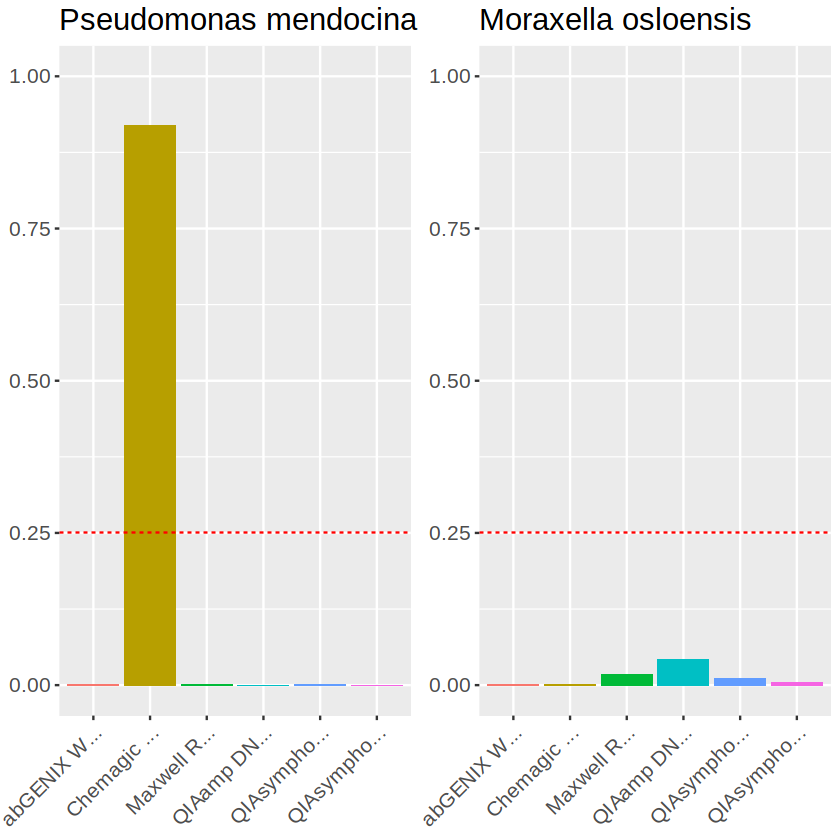

In [14]:
get_prev_plot <- function(taxon) {
    contam_plt <- prev_df %>%
        left_join(meta) %>%
        group_by(extraction_kit) %>%
        summarise(prev = sum(get(taxon)) / n(), n = n()) %>%
        filter(extraction_kit != "Unknown") %>%
        ggplot(aes(x = extraction_kit, y = prev, fill = extraction_kit)) +
            geom_bar(stat = "identity") +
            theme(axis.text.x = element_text(angle = 45, hjust = 1),
                  axis.title = element_blank(),
                  text = element_text(size = 15)) +
            scale_x_discrete(label = function(x) stringr::str_trunc(x, 12)) +
            labs(x = "Extraction Kit", y = "Prevalence", title = taxon) +
            geom_hline(yintercept = 0.25, 
                       color = "red",
                       lty = "dashed") +
            ylim(0, 1)
    }
                         
                    
                    
ggarrange(get_prev_plot("Pseudomonas mendocina"), get_prev_plot("Moraxella osloensis"), 
          common.legend = T,
          legend = "none")
                             
ggsave("results/decontamination/contam_versus_nc_prevalence.png", dpi = 600, height = 6.67, width = 7.5)

#### Compare with fine grain analysis

In [15]:
# global_not_fine <- read.csv("results/decontamination/global_not_fine_taxa.txt")$taxa
# length(global_not_fine)
# prev_max_filt %>% 
#     filter(taxa %in% global_not_fine) %>%
#     separate(taxa, sep = " ", into = c("genus", "species")) %>%
#     group_by(genus) %>%
#     summarise(n = n()) %>%
#     arrange(desc(n))

### Rank species by prevalence and max read count

In [16]:
top_max_count <- prev_max_filt %>% 
    arrange(desc(max_count)) %>% 
    mutate(count_rank = seq(nrow(prev_max_filt)))

top_prev <- prev_max_filt %>% 
    arrange(desc(overall_prevalence)) %>%
    mutate(prev_rank = seq(nrow(prev_max_filt)))

top_max_count %>% 
    full_join(top_prev) %>%
    mutate(ranksum = count_rank + prev_rank) %>%
    arrange(prev_rank)

Joining, by = c("taxa", "max_count", "overall_prevalence", "n_samples", "max_bin")



taxa,max_count,overall_prevalence,n_samples,max_bin,count_rank,prev_rank,ranksum
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>
Cutibacterium acnes,22596,0.047462619,419,>=500,6,1,7
Microbacterium sp. PM5,83419,0.035681921,315,>=500,4,2,6
Pseudomonas tolaasii,161,0.024014499,212,100-500,132,3,135
Moraxella osloensis,2402,0.019143634,169,>=500,28,4,32
Mesorhizobium sp. Pch-S,405,0.019143634,169,100-500,80,5,85
Human mastadenovirus C,17475,0.018577254,164,>=500,8,6,14
Paraburkholderia sp. 7MH5,182,0.015745356,139,100-500,126,7,133
Paraburkholderia tropica,153,0.014839148,131,100-500,136,8,144
Paraburkholderia acidiphila,188,0.014499320,128,100-500,123,9,132


### Get samples with max. read counts

#### Get metadata of top 20 bacterial taxa ranked by max count

In [17]:
top_20 <- top_max_count %>%
    filter(!grepl("Human", taxa)) %>%
    select(taxa, max_count, overall_prevalence, n_samples) %>%
    head(20)

morsels <- foreach (i = seq(nrow(top_20))) %do% {
    row <- top_20[i, ]
    taxon <- row$taxa
    max_count <- row$max_count
    sample_with_max_count <- (species_filt %>% filter(get(taxon) == max_count))$npm_research_id
    
    RA <- species_filt_RA %>% 
        filter(npm_research_id == sample_with_max_count) %>%
        select(all_of(taxon))
    RA <- deframe(RA)
    
    row$max_sample <- sample_with_max_count
    row$rel_a <- RA
    
    return(row)
}

top_20_parsed <- bind_rows(morsels)

top_20_parsed

fwrite(top_20_parsed, "results/irep_analysis/global_top_20_bacteria_max_count.csv")

taxa,max_count,overall_prevalence,n_samples,max_sample,rel_a
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Fusobacterium nucleatum,194199,0.0011327594,10,WHB4594,0.98161112
Staphylococcus haemolyticus,117929,0.0105346624,93,0416-0024,0.86270364
Paracoccus yeei,85256,0.0035115541,31,WHH1680,0.97894133
Microbacterium sp. PM5,83419,0.0356819212,315,WHB10821,1.00000000
Microbacterium sp. Nx66,67485,0.0137063888,121,WHB3375,1.00000000
Cutibacterium acnes,22596,0.0474626189,419,WHB8433,1.00000000
Staphylococcus cohnii,18768,0.0080425918,71,0416-0024,0.13729636
Neisseria subflava,15385,0.0015858632,14,WHB9179,0.27026315
Corynebacterium segmentosum,14476,0.0010194835,9,WHB6459,0.51296953


[1] "WHB10821"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 8513 rows containing non-finite values (stat_bin).”


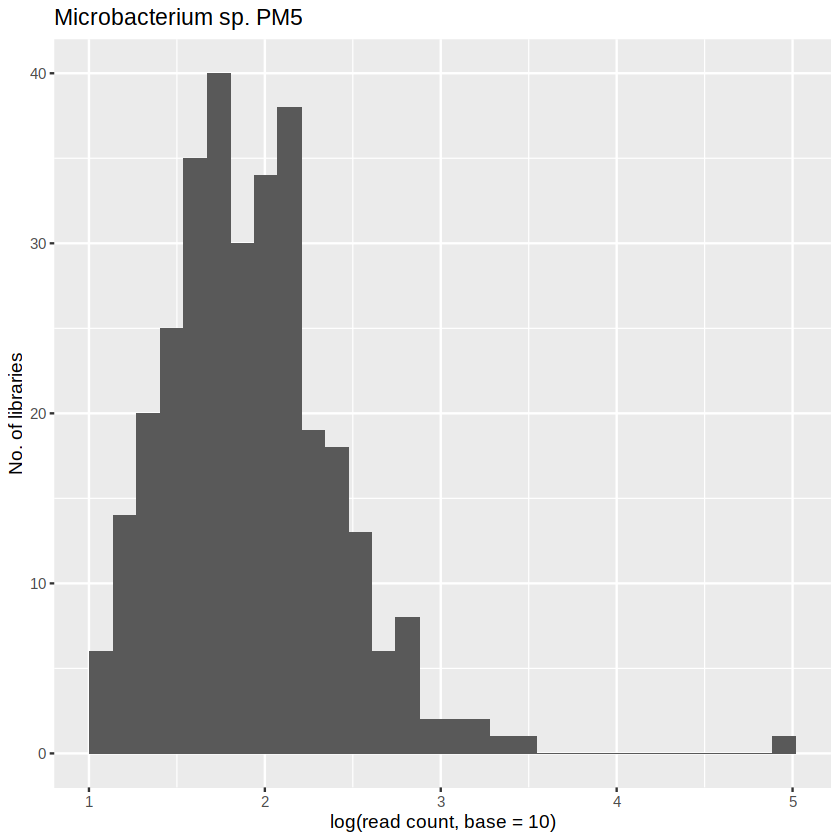

In [18]:
# taxon <- "Paracoccus yeei"
# taxon <- "Fusobacterium nucleatum"
# taxon <- "Cutibacterium acnes"
# taxon <- "Bacillus cereus"
taxon <- "Burkholderia contaminans"
# taxon <- "Microbacterium hominis"
taxon <- "Microbacterium sp. PM5"
max_count <- prev_max_filt[prev_max_filt$taxa == taxon, ]$max_count
id <- (species_filt %>%
    filter(get(taxon) == max_count))$npm_research_id
print(id)

# species_RA %>% 
#     filter(npm_research_id == id) %>%
#     select(all_of(c(taxon)))

species_filt %>%
    select(all_of(c("npm_research_id", taxon))) %>%
    arrange(desc(get(taxon))) %>%
#     filter(get(taxon) > 100) %>%
    ggplot(aes(x = log(get(taxon), base = 10))) +
    geom_histogram() +
    labs(x = "log(read count, base = 10)", y = "No. of libraries", title = taxon)

### No. of taxa per sample

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



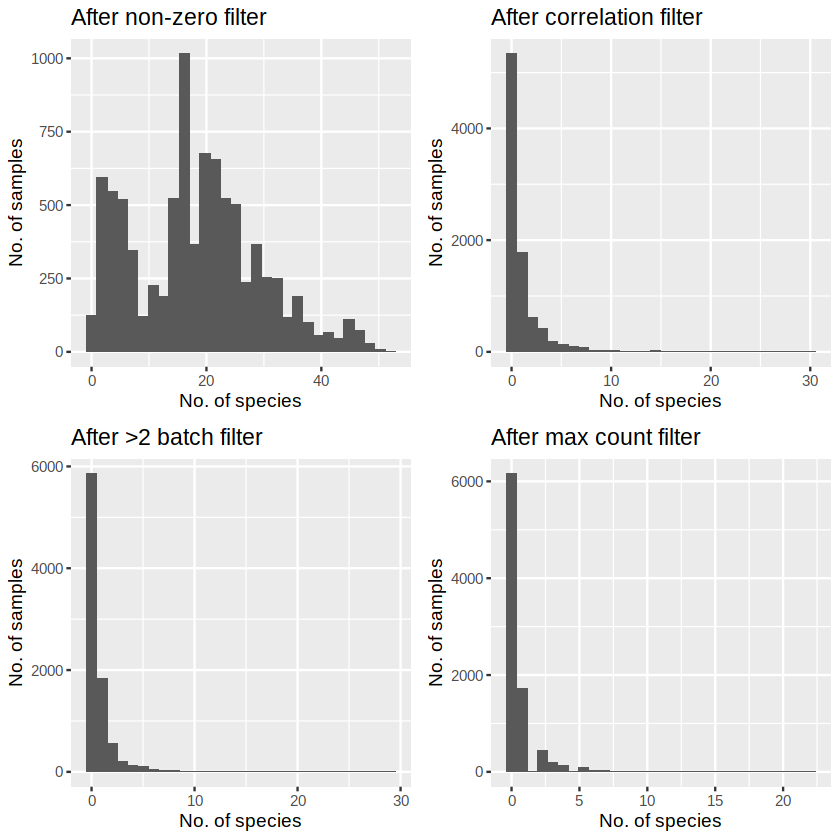

In [19]:
# After PA thresholding
tax_plt <- tibble(n = rowSums(prev_df %>% select(-npm_research_id))) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After non-zero filter")

# After correlation decontamination
species_prev_filt1 <- prev_df %>% select(all_of(corr_nc))
tax_plt1 <- tibble(n = rowSums(species_prev_filt1)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After correlation filter")

# After simple batch filter
species_prev_filt2 <- prev_df %>% select(all_of(batch_nc))
tax_plt2 <- tibble(n = rowSums(species_prev_filt2)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After >2 batch filter")


# After max count filter
species_prev_filt3 <- prev_df %>% select(all_of(prev_max_filt$taxa))
tax_plt3 <- tibble(n = rowSums(species_prev_filt3)) %>%
    ggplot(aes(x = n)) +
    geom_histogram() +
    labs(x = "No. of species", y = "No. of samples", title = "After max count filter")

ggarrange(tax_plt, tax_plt1, tax_plt2, tax_plt3)

In [20]:
sum(rowSums(species_prev_filt3) == 0)

[1] 6154

## Visualising batch effects (PCoA)

#### CLR transformation

In [21]:
X_before <- RA_to_clr(otu_to_RA(species_zeroed %>% rownames_to_column("npm_research_id"))) %>% 
    column_to_rownames("npm_research_id")
X_after <- RA_to_clr(otu_to_RA(species_read_final)) %>% 
    column_to_rownames("npm_research_id")
# # Get Bray-curtis dists
# dist_before <- dist(as.matrix(X_before),  method = "euclidean")
# dist_after <- dist(as.matrix(X_after),  method = "euclidean")

#### Run PCA analysis on CLR abundances

Joining, by = "npm_research_id"

Joining, by = "npm_research_id"

Saving 12 x 6.67 in image

Joining, by = "npm_research_id"



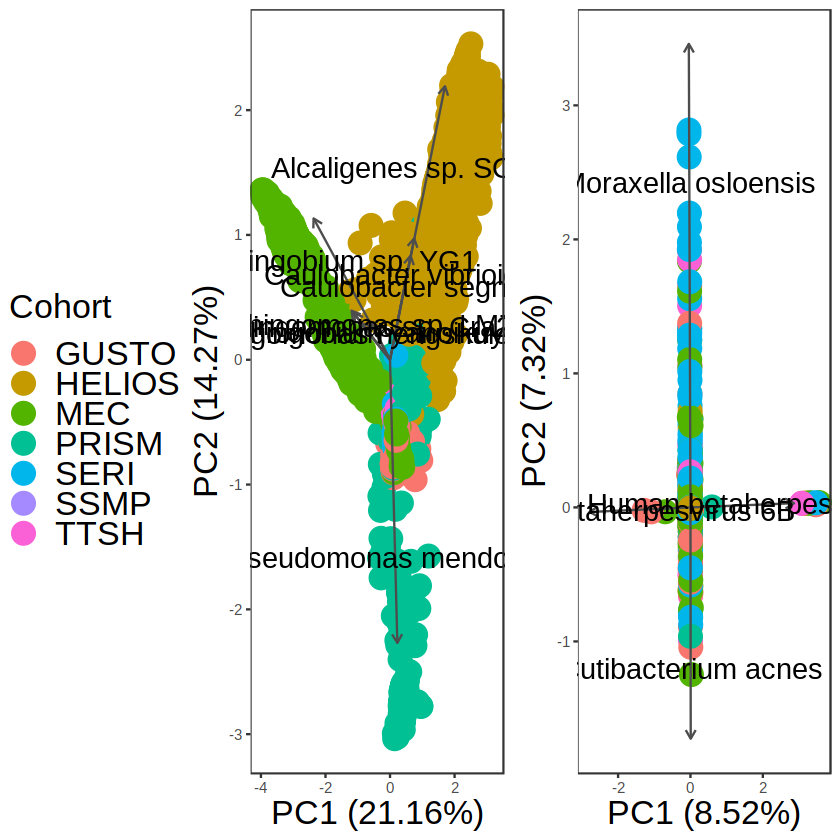

Saving 6.67 x 6.67 in image

Joining, by = "npm_research_id"



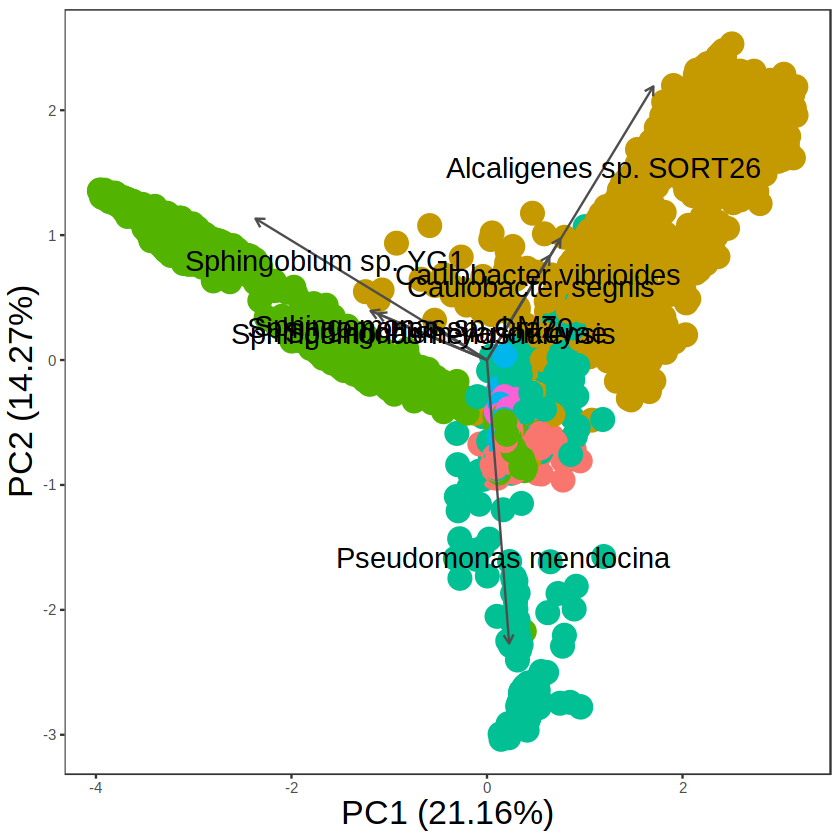

Saving 6.67 x 6.67 in image



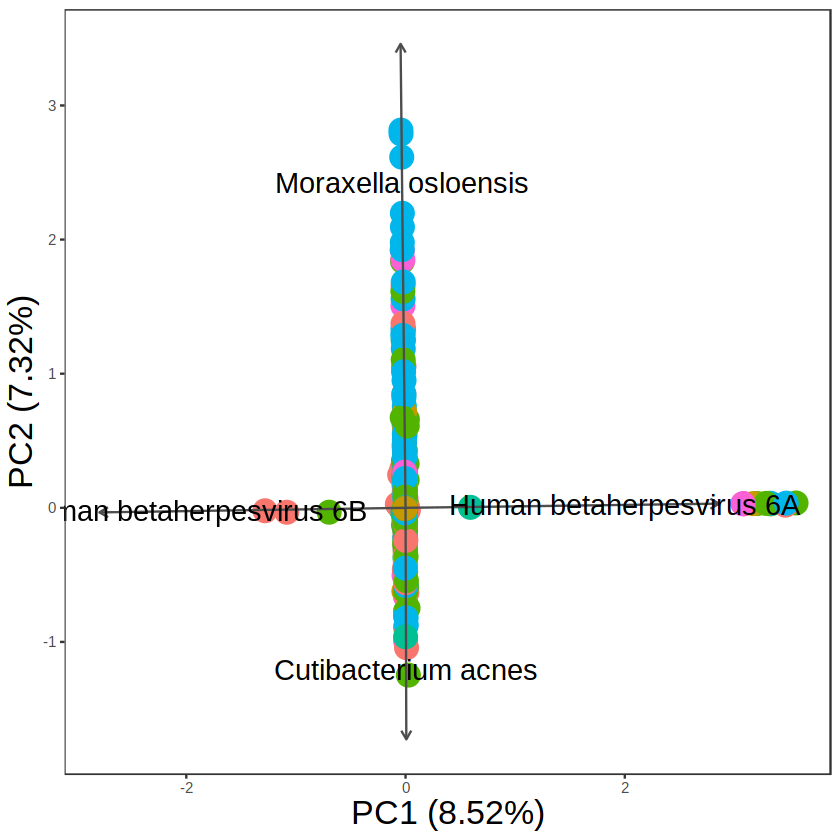

In [22]:
get_pca_plot <- function(X, loadings_scale_factor = 4) {
    # Run Singular Value Decomposition
    pca <- prcomp(X, retx = T)
    
    # Extract loadings
    loadings <- data.frame(Variables = rownames(pca$rotation), pca$rotation) %>%
    mutate(sum_pc = abs(PC1) + abs(PC2)) %>%
    filter(sum_pc > 0.2)
    
    # Extract proportion of variance
    prop_variance <- pca$sdev ^ 2 / sum(pca$sdev ^ 2)
    PC1_prop <- round(prop_variance[1] * 100, 2)
    PC2_prop <- round(prop_variance[2] * 100, 2)
    
    # Plot
    as_tibble(pca$x) %>%
        add_column(npm_research_id = rownames(pca$x), .before = 1) %>%
        left_join(meta) %>%
        ggplot(aes(x = PC1, y = PC2, color = site_supplying_sample)) +
        geom_point(size = 6) + 
        geom_segment(data = loadings, 
                     aes(x = 0, y = 0, 
                         xend = (PC1 * loadings_scale_factor),
                         yend = (PC2 * loadings_scale_factor)), 
                     arrow = arrow(length = unit(1/2, "picas")),
                     color = "grey30") +
        annotate("text", 
                 size = 6,
                 x = (loadings$PC1 * loadings_scale_factor * 0.7), 
                 y = (loadings$PC2 * loadings_scale_factor * 0.7),
                 label = loadings$Variables) +
    labs(x = str_glue("PC1 ({PC1_prop}%)"), 
         y = str_glue("PC2 ({PC2_prop}%)"), 
         color = "Cohort") +
    theme_bw() +
    theme(panel.grid = element_blank(),
          axis.title = element_text(size = 20),
          legend.text = element_text(size = 20),
          legend.title = element_text(size = 20),
          legend.position = "none")
    
}

ggarrange(get_pca_plot(X_before),
          get_pca_plot(X_after), 
          common.legend = T,
          legend = "left")

ggsave("results/decontamination/PCoA_Aitchinson.png", dpi = 600, width = 12)
# Get separate plots
get_pca_plot(X_before)
ggsave("results/decontamination/PCoA_Aitchinson_before.png", dpi = 600)
get_pca_plot(X_after)
ggsave("results/decontamination/PCoA_Aitchinson_after.png", dpi = 600)
# ggsave("results/decontamination/PCoA_Aitchinson.png", dpi = 600, width = 12)

# ggarrange(get_pca_plot(X_before),
#           get_pca_plot(X_after), 
#           common.legend = T,
#           legend = "none")

# ggsave("results/decontamination/PCoA_Aitchinson_nolegend.png", dpi = 600, width = 12, height = 6)

#### Extract loadings

In [23]:
# Extract loadings of the variables
loadings_before <- data.frame(Variables = rownames(pca_before$rotation), pca_before$rotation) %>%
    mutate(sum_pc = abs(PC1) + abs(PC2)) %>%
    filter(sum_pc > 0.2)

loadings_after <- data.frame(Variables = rownames(pca_after$rotation), pca_after$rotation) %>%
    mutate(sum_pc = abs(PC1) + abs(PC2)) %>%
    filter(sum_pc > 0.2)

ERROR: Error in rownames(pca_before$rotation): object 'pca_before' not found


#### Extract eigenvalues

In [ ]:
loadings_scale_factor <- 3
as_tibble(pca_before$x) %>%
    add_column(npm_research_id = rownames(pca_before$x), .before = 1) %>%
    left_join(meta) %>%
    ggplot(aes(x = PC1, y = PC2, color = site_supplying_sample)) +
    geom_point() + 
    geom_segment(data = loadings_before, aes(x = 0, y = 0, xend = (PC1 * loadings_scale_factor),
                 yend = (PC2 * loadings_scale_factor)), arrow = arrow(length = unit(1/2, "picas")),
                 color = "black") +
    annotate("text", 
             x = (loadings_before$PC1 * loadings_scale_factor), 
             y = (loadings_before$PC2 * loadings_scale_factor),
             label = loadings_before$Variables)

as_tibble(pca_after$x) %>%
    add_column(npm_research_id = rownames(pca_before$x), .before = 1) %>%
    left_join(meta) %>%
    ggplot(aes(x = PC1, y = PC2, color = site_supplying_sample)) +
    geom_point() + 
    geom_segment(data = loadings_after, aes(x = 0, y = 0, xend = (PC1 * loadings_scale_factor),
                 yend = (PC2 * loadings_scale_factor)), arrow = arrow(length = unit(1/2, "picas")),
                 color = "black") +
    annotate("text", 
             x = (loadings_after$PC1 * loadings_scale_factor), 
             y = (loadings_after$PC2 * loadings_scale_factor),
             label = loadings_after$Variables)
